In [3]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims
import cv2

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

import random

In [4]:
# Seed randomness.

from numpy.random import seed
seed(1)
tf.random.set_seed(2)
# tf 2 -> 9.389878408837536

In [5]:
data = np.load('training_images_original.npz', allow_pickle=True)

In [6]:
# Extract the images - Train.
train_images = data['images']
# and the data points. - iBUG 300-W
train_pts = data['points']
# Print data shape.
print("Image Data Shape: {}, Points Data Shape: {}".format(train_images.shape,train_pts.shape))

Image Data Shape: (2811, 250, 250, 3), Points Data Shape: (2811, 68, 2)


In [7]:
train_pts[0]

array([[ 49.5003016 ,  96.36088652],
       [ 51.89436619, 116.40425472],
       [ 57.21595534, 137.51551684],
       [ 63.00176855, 158.18841025],
       [ 70.29497793, 177.53063626],
       [ 83.22774767, 194.40241954],
       [ 98.46640371, 210.33634986],
       [114.14377327, 222.98946016],
       [134.60774524, 225.34462035],
       [154.10979319, 221.33704392],
       [171.23999981, 207.97731754],
       [185.92978321, 192.09175507],
       [199.67156931, 173.04923694],
       [205.25735085, 157.24365152],
       [206.0145981 , 137.95031177],
       [206.32044173, 112.09256643],
       [207.05689479,  88.48576906],
       [ 57.7100546 ,  84.40416977],
       [ 69.42551022,  77.675049  ],
       [ 82.43654478,  77.03837447],
       [ 94.09185892,  80.75641089],
       [106.93715678,  85.69284648],
       [130.65823677,  84.57572489],
       [144.20256597,  78.19311575],
       [157.63086329,  74.21681033],
       [170.69109972,  70.62775008],
       [187.86481377,  73.85157082],
 

In [8]:
#@title Preprocessing - Clip Negative Points.

# Ensure all training points within 0-250 range.
train_pts = np.clip(train_pts,0,250)

<br>

In [9]:
#@title Function - Visualize Images and Points
def visualise_pts(img, pts, title_num=0):
  titles = ["Ground Truth Points", "Predictions"]
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.title(titles[title_num])
  plt.show()

In [10]:
#@title Function - Calculating Prediction Error and exporting results
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [11]:
#@title Function - Plot average Euclidian Distance.
# Across Facial Area Slices of the 68 Points.

def average_euclidian_dist(preds):
  """
  Calculate the avg euclidean distance between predictions and ground truth.
  :param preds: The Model Predictions.
  :return: The mean euclidian distance of all points across all images.
  """

  # Lists to hold values for averaging.
  euclid_total_list = list()
  euclid_facebounds_list = list()
  euclid_eyebrows_list = list()
  euclid_nose_list = list()
  euclid_eyes_list = list()
  euclid_mouth_list = list()

  for i in range(500):
    # Calculate Euclidian Distance values for each Image.
    euclid_totals = euclid_dist(preds[i].reshape(68,2),train_pts[2311+i])
    euclid_total_list.append(euclid_totals)
    # Mean Euc. Dist. across face outline.
    euclid_facebounds_list.append(np.mean(euclid_totals[0:17]))
    # Mean Euc. Dist. across eyebrows.
    euclid_eyebrows_list.append(np.mean(euclid_totals[18:27]))
    # Mean Euc. Dist. across nose.
    euclid_nose_list.append(np.mean(euclid_totals[28:36]))
    # Mean Euc. Dist. across eyes.
    euclid_eyes_list.append(np.mean(euclid_totals[37:48]))
    # Mean Euc. Dist. across mouth.
    euclid_mouth_list.append(np.mean(euclid_totals[49:68]))

  # Calculate averages across all test images.
  euclid_total_vals = np.mean(euclid_total_list)
  euclid_facebounds_total = np.mean(euclid_facebounds_list)
  euclid_eyebrows_total = np.mean(euclid_eyebrows_list)
  euclid_nose_total = np.mean(euclid_nose_list)
  euclid_eyes_total = np.mean(euclid_eyes_list)
  euclid_mouth_total = np.mean(euclid_mouth_list)



  facial_areas = ["Face Bounds", "Eyebrows", "Nose", "Eyes", "Mouth", "All Areas"]
  # Avg areas for bar plot.
  facial_area_vals = [euclid_facebounds_total, euclid_eyebrows_total,
                      euclid_nose_total, euclid_eyes_total,
                      euclid_mouth_total, euclid_total_vals]

  fig, ax = plt.subplots()
  ax.set_ylabel("Mean Euc. Dist.")

  # Use below to print bar height on plot.
  rects1 = ax.bar(facial_areas,facial_area_vals, color="g")
  def autolabel(rects):
  # http://matplotlib.org/examples/api/barchart_demo.html
      """
      Attach a text label above each bar displaying its height
      Slightly Modded
      """
      height_list = []
      for rect in rects:
          height = rect.get_height()
          height_list.append(height)
          ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                  '%d' % int(height),
                  ha='center', va='bottom')
      return max(height_list)

  # Force y_lim to have space for all values incase some do not appear.
  max_height = autolabel(rects1)
  ax.set_ylim(0,max_height+max_height/5)
  # Plot
  plt.title("Average Euclidian Distances")
  plt.show()
  # Print total avg. distance.
  print("Mean Euclidian Distance All Images and Points: {}".format(euclid_total_vals))

  # Return total avg euclid distance.
  return euclid_total_vals

In [12]:
#@title Function - Face Segmentation and Graphical Demonstration - Extensions

def face_segmentation(image_data=train_images[0],landmark_points=train_pts[0], truth_or_prediction=0):
  """
  Segment Areas of face using images and points, either ground truth or predicted is fine.
  :param image_data: Image.
  :param landmark_points: Points used for face segmentation for said image - Assuming IBUG 68 points.
  :param truth_or_prediction image/points being used. Not very necessary but was for ease of manipulation further down line.
  :return: The coordinates of the facial area only (Face bounds to Eyebrows).
  """
  if truth_or_prediction:
    # If prediction: Additional Augmentation
    # Eg. Function Call: face_segmentation(X_test[109],predictions[109].reshape(68,2),truth_or_prediction=1)
    image_data = image_data * 255
    image_data = image_data.astype(np.uint8)

  ######### - Code necessary for pixels in face seg.
  # Seperate Areas of face for segmentation.
  p1 = landmark_points.astype(np.uint8)[0].reshape(1,-1)
  p2 = landmark_points.astype(np.uint8)[17:27]
  p3 = landmark_points.astype(np.uint8)[16::-1]
  poly_face = np.concatenate((p1,p2,p3))

  # Create copy of original image
  img = image_data.copy()
  
  # Map area of face.
  img = cv2.fillPoly(img, np.array([poly_face], dtype=np.int32), color=(255,255,255))
  # img = cv2.fillPoly(img, np.array([poly_face,poly_face], dtype=np.int32), color=(255,255,255))

  # mask stores array where elements equal 255 or then 0.
  mask = img.copy().astype(np.uint8)


  # Create copy for graphical demo.
  mask_black = img.copy()
  # Set mask to 0 if not white space to create mask.
  mask[mask<255] = 0
  # Set cut of original image to black for graphical demo.
  mask_black[mask_black==255] = 0

  # Coordinates where value is greater than 0. I.e. all pixels
  # within the facebounds.
  segmented_coordinates = np.column_stack(np.where(mask > 0))
  ######### - Rest is graphical demonstration.

  # Inverted mask for graphical demo.
  mask_inv = cv2.bitwise_not(mask)
  # Copy original image again.
  holding_image = image_data.copy()
  # Average.
  img_gray = np.mean(holding_image, axis=2).astype('uint8')
  # Create threshold image.
  binary = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
  # Average inverted mask
  avg_mask_inv = np.mean(mask_inv,axis=2).astype("uint8")
  # Create line drawing of facial area
  line_drawing = cv2.add(binary,avg_mask_inv)
  # Bitwise line drawings
  threshold_inverted = cv2.bitwise_not(line_drawing)
  avg_mask_black = np.mean(mask_black,axis=2).astype("uint8")
  b = cv2.add(avg_mask_black,threshold_inverted)


  fig, axarr = plt.subplots(3,2, figsize=(10,10))
  # Original Image
  axarr[0,0].set_title("Original Image")
  axarr[0,0].imshow(image_data)
  # Face Segmented
  axarr[0,1].set_title("Segmented Face: Ground Truth")
  if truth_or_prediction:
    axarr[0,1].set_title("Segmented Face: Predicted Points")
  axarr[0,1].imshow(img)
  # Face Segmented - Mask
  axarr[1,0].set_title("Mask")
  axarr[1,0].imshow(mask)
  # Thresholded face on white background
  axarr[1,1].set_title("Threshold Face")
  axarr[1,1].imshow(line_drawing, cmap="gray")
  # Thresholded face on white background - Inverted
  axarr[2,0].set_title("Inverted Threshold")
  axarr[2,0].imshow(threshold_inverted,cmap="gray")
  # Inverted Face added to np.mean(img)
  axarr[2,1].set_title("Graphical Demonstation")
  axarr[2,1].imshow(b,cmap="gray")
  plt.show()

  # UnComment for another weird photo.
  # Left out because it didnt fit in plot and at this point i didnt really know
  # what image i was going for anymore just thought it might look cool.
  # lines = line_drawing.copy()
  # t = cv2.bitwise_and(lines,cv2.bitwise_not(avg_mask_black))
  # plt.imshow(t,cmap="gray")
  # plt.show()

  return segmented_coordinates

In [13]:
#@title Function - Custom Shuffler - Maintain Order
def shuffler(images,points):
  """
  Shuffle images and points whilst maintaining order.
  :param images: Array of images to be shuffled.
  :param points: Array of points to be shuffled.
  :return: Shuffled images, shuffled points
  """
  indices = np.arange(images.shape[0])
  np.random.shuffle(indices)

  images = images[indices]
  points = points[indices]

  return images, points

In [14]:
#@title Function Augmentation - Flip Image
def flip_sample(image,points):
  """
  Flip Image and Points.
  :param image: Image to be flipped.
  :param points: Points of corresponding image to be flipped.
  :return: Flipped pair of image and point.
  """
  # Copy images/points.
  img = image.copy()
  pts = points.copy()
  # Create flips of original data
  flipped = img[:,::-1]
  pts[:,0] = 250 - pts[:,0]

  return flipped, pts

In [15]:
#@title Function Augmentation - Rotate Set of Image, Points
def rotate_img_pts(image, points, theta):
  """
  Rotate image and points by angle theta.
  :param image: Image to be rotated.
  :param points: Points of corresponding image to be rotated.
  :param theta: Angle to rotate images by. N.B. As with any rot. mat. switch sign for other dir.
  :return: Rotated pair of image and point.
  """
  img = image.copy()
  pts = points.copy()
  # Get shape of image for point of rotation.
  cols, rows = img.shape[0:2]
  center_point = (cols/2,rows/2)
  # Rotation Matrix
  rotation_matrix = cv2.getRotationMatrix2D(center_point, theta, 1.0)
  # Rotate Image
  rot_image = cv2.warpAffine(img, rotation_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)
  # Rotate Points
  ones = np.ones(shape=(len(pts), 1))
  points_ones = np.hstack([pts, ones])
  rot_pts = rotation_matrix.dot(points_ones.T).T

  return rot_image, rot_pts

In [16]:
#@title Function Augmentation - Pixel Intensity Augmentation
def pixel_intensity_aug(image,points):
  """
  Augment pixel intensity.
  :param image: Image to be 'brightened'.
  :param points: Points of corresponding image.
  :return: Augmented pair of image and point.
  """
  # Create copy of original Image.
  data = image.copy()
  pts = points.copy()
  # Expand dimensions of image.
  samples = expand_dims(data,0)
  # Probability to decide if darker or brighter.
  p = random.uniform(0,1)
  if p < 0.5:
    datagen = ImageDataGenerator(brightness_range=[0.7,0.8])
  else:
    datagen = ImageDataGenerator(brightness_range=[1.2,1.3])
  it = datagen.flow(samples, batch_size=1)
  batch = it.next()
  new_image = batch[0].astype("uint8")
  # Return new image and the corresponding points.
  return new_image, pts

<br>

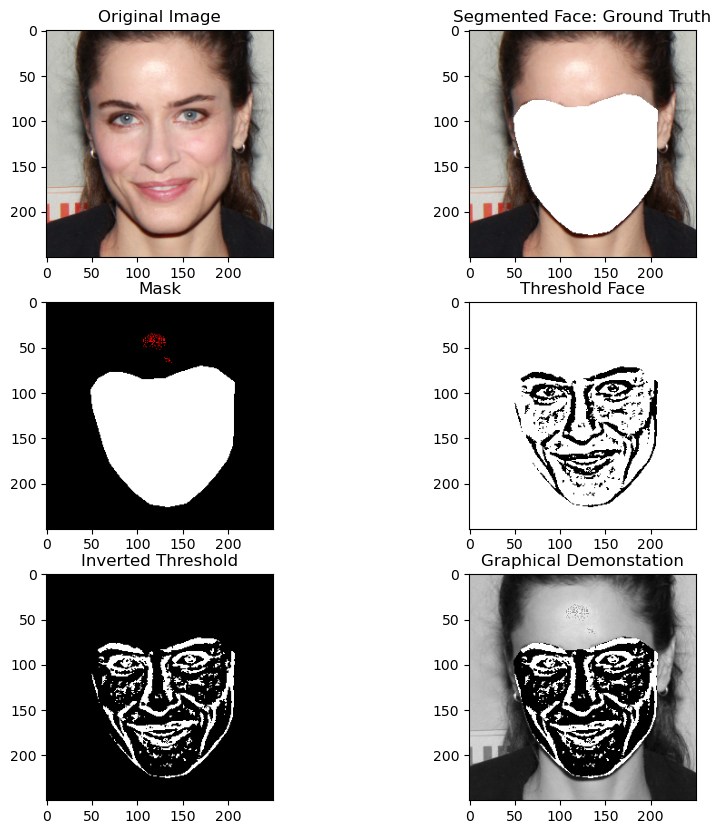

array([[ 34, 116,   0],
       [ 35, 115,   0],
       [ 35, 117,   0],
       ...,
       [225, 136,   0],
       [225, 136,   1],
       [225, 136,   2]], dtype=int64)

In [17]:
#@title Graphical Demo on Ground Truth Points + Return coordinates of face points
# N.B. Will work with predicted points once created.

img_num = 0
#visualise_pts(train_images[img_num],train_pts[img_num],0)
face_segmentation(train_images[img_num],train_pts[img_num],truth_or_prediction=0)

Flipped Image


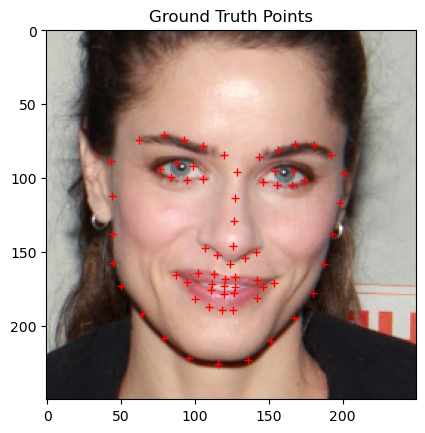

Image rotated by 10 degrees


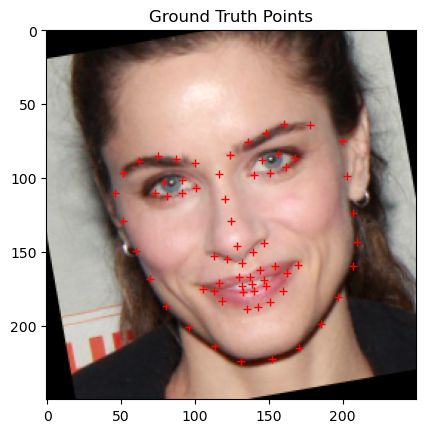

Pixel Intensity Augmentation


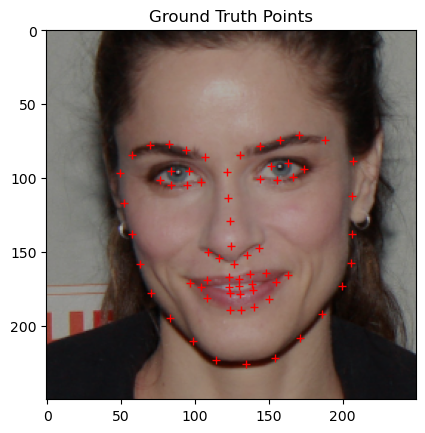

In [18]:
#@title Visualize Data Augmentation.

img_num = 0

# Flip Image.
print("Flipped Image")
z,c = flip_sample(train_images[img_num],train_pts[img_num])
visualise_pts(z,c,0)

# Rotated Image.
angle = 10
z,c = rotate_img_pts(train_images[img_num], train_pts[img_num],angle)
print("Image rotated by {} degrees".format(angle))
visualise_pts(z, c,0)

# Pixel Intensity.
print("Pixel Intensity Augmentation")
z,c = pixel_intensity_aug(train_images[img_num],train_pts[img_num])
visualise_pts(z,c,0)

In [28]:
#@title No Data Augmentation
#######################################
# max_num if not using data augmentation.
# Please run as it declares a variable used later on.
#######################################
max_num = 0

<br>

PLEASE Only run the next 3 cells if you want to see the effect of data augmentation on either the training array or even the model. It has a NEGATIVE effect on model. 
<br>For that reason code is commented out to start though please feel free to uncomment to read through the steps.

In [29]:
#@title Data Augmentation
# Functionality to flip all images and points.
##### Please exercise caution if changing number of new points to be created to avoid adding empty arrays.

# # How many points to be augmented.
# max_num = 250
# # Create empty storage arrays.
# empty_images = np.empty_like(train_images[:max_num])
# empty_pts = np.empty_like(train_pts[:max_num])
# # Counter for indexing into empty arrays.
# counter = 0
# # Hold indicies of all images that were augmented.
# index_list = list()

# # Enumerate through original data.
# for i, (img,pts) in enumerate(zip(train_images,train_pts)):
#   p = np.random.random(1)[0]

#   # Flip Image:
#   if p < 0.05:
#     # Store index of augmented data.
#     index_list.append(i)
#     image, points = flip_sample(img,pts)
#     # Insert in storage arrays.
#     empty_images[counter] = image
#     empty_pts[counter] = points
#     # Update how many new data items have been created.
#     counter+=1
#   # Rotate Image:
#   elif p < 0.1:
#     # Store index of augmented data.
#     index_list.append(i)
#     angle_list = [-10, -5, 5, 10]
#     angle = random.choices(angle_list)[0]
#     image, points = rotate_img_pts(img,pts,angle)
#     # Insert in storage arrays.
#     empty_images[counter] = image
#     empty_pts[counter] = points
#     # Update how many new data items have been created.
#     counter+=1
#   # Augment pixel intensity:
#   elif p < 0.15:
#     # Store index of augmented data.
#     index_list.append(i)
#     image, points = pixel_intensity_aug(img,pts)
#     # Insert in storage arrays.
#     empty_images[counter] = image
#     empty_pts[counter] = points
#     # Update how many new data items have been created.
#     counter+=1

#   if counter == max_num:
#     # End loop if max_num new data items created.
#     break


# # Append storage arrays onto main data.
# train_images = np.append(train_images,empty_images,axis=0)
# train_pts = np.append(train_pts,empty_pts,axis=0)

In [30]:
#@title Visualize Augmented Array
# aug_index_num = 0
# original_length = 2811
# print("Augmented Data:")
# # visualise_pts(empty_images[aug_index_num],empty_pts[aug_index_num])
# visualise_pts(train_images[original_length+aug_index_num],train_pts[original_length+aug_index_num])
# print("Original Data:")
# original_num = index_list[aug_index_num]
# visualise_pts(train_images[original_num],train_pts[original_num])

In [31]:
#@title Shuffle Data
# train_images, train_pts = shuffler(train_images,train_pts)

<br>

In [ ]:
#@title FINAL MODEL
# Current Best 

# Norm X
norm_train_images = train_images/255
# Train Test split
X_train = norm_train_images[:-500]
X_test = norm_train_images[-500:]

# Norm y
y = train_pts/250
y = np.reshape(y,(-1,136))
# Train Test split
y_train = y[:-500]
y_test = y[-500:]


# CNN
first_filters = 64
second_filters = 98
third_filters = 136

kernel_size = (3,3)
pool_size = (2,2)


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(first_filters, kernel_size, activation="relu"))
model.add(Conv2D(first_filters, kernel_size, activation="relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(third_filters))
model.add(Activation("sigmoid"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mse"])

history = model.fit(X_train,y_train, epochs=5, batch_size=32, validation_data=(X_test,y_test))




Epoch 1/5


 5/73 [=>............................] - ETA: 34:21 - loss: 0.0257 - mse: 0.0257

In [ ]:
#@title Graphical Interpretations
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])#, loc='upper left')
plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'])#, loc='upper left')
# plt.show()

In [ ]:
#@title Model Summary
model.summary()

In [ ]:
#@title Predictions on subset of training data.
# Please amend array slices in model cell as to
# not test on data already seen by the CNN.
predictions = model.predict(X_test) 
predictions *= 250

In [ ]:
#@title Visualization

# Keep count of additional data from augmentation.
additional_augs = max_num

# Predictions on Empty Image
npArray = np.array([[[0, 162, 232, 255]]], dtype='uint8')
for i in range(23,25):
    visualise_pts(npArray, train_pts[2311+additional_augs+i, ...],0)
    visualise_pts(npArray, predictions[i, ...].reshape(68,2),1)

# Visualize Ground Truth vs predictions on Test (train split) Images
for i in range(23,25):
    visualise_pts(train_images[2311+additional_augs+i, ...], train_pts[2311+additional_augs+i, ...],0)
    visualise_pts(X_test[i, ...], predictions[i, ...].reshape(68,2),1)

In [ ]:
#@title Bar Plot
average_euclidian_dist(predictions)

In [ ]:
# Segmenting faces using predicted points.
img_num = 24
# Using Ground Truth.
face_segmentation(train_images[img_num+2311+additional_augs],train_pts[img_num+2311+additional_augs],truth_or_prediction=0)
# Using Predicted Points.
face_segmentation(X_test[img_num],predictions[img_num].reshape(68,2),truth_or_prediction=1)

<br>

In [ ]:
#@title Create and Reshape answers.
answers = model.predict(test_images/255)
answers *= 250
reshaped_answers =  answers.reshape(-1,68,2)

In [ ]:
#@title Predictions on Empty Image
npArray = np.array([[[0, 162, 232, 255]]], dtype='uint8')
for i in range(2):
    visualise_pts(npArray, answers[i, ...].reshape(68,2),1)
    visualise_pts(test_images[i, ...], answers[i, ...].reshape(68,2),1)

In [ ]:
#@title Graphical Demo on Predictions
img_num = 0
face_segmentation((test_images/255)[img_num],answers[img_num].reshape(68,2),truth_or_prediction=1)

In [ ]:
#@title Function Save as CSV
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [ ]:
from google.colab import files
!ls
save_as_csv(reshaped_answers)
files.download("results.csv")

In [ ]:
#@title Plot Example Images and Predictions
fig, axarr = plt.subplots(2,3, figsize=(15,15))
axarr[0,0].imshow(example_images[0])
axarr[0,0].plot(preds[0].reshape(68,2)[:, 0], preds[0].reshape(68,2)[:, 1], '+r')
axarr[0,0].axis("off")

axarr[0,1].imshow(example_images[1])
axarr[0,1].plot(preds[1].reshape(68,2)[:, 0], preds[1].reshape(68,2)[:, 1], '+r')
axarr[0,1].axis("off")

axarr[0,2].imshow(example_images[2])
axarr[0,2].plot(preds[2].reshape(68,2)[:, 0], preds[2].reshape(68,2)[:, 1], '+r')
axarr[0,2].axis("off")

axarr[1,0].imshow(example_images[3])
axarr[1,0].plot(preds[3].reshape(68,2)[:, 0], preds[3].reshape(68,2)[:, 1], '+r')
axarr[1,0].axis("off")

axarr[1,1].imshow(example_images[4])
axarr[1,1].plot(preds[4].reshape(68,2)[:, 0], preds[4].reshape(68,2)[:, 1], '+r')
axarr[1,1].axis("off")

axarr[1,2].imshow(example_images[5])
axarr[1,2].plot(preds[5].reshape(68,2)[:, 0], preds[5].reshape(68,2)[:, 1], '+r')
axarr[1,2].axis("off")

plt.axis("off")
fig.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("Example Images.png", dpi=300)
plt.show()

<br>

In [ ]:
#@title Model_ONE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Norm X
norm_train_images = train_images/255
# Train Test split
X_train = norm_train_images[:-500]
X_test = norm_train_images[-500:]

# Norm y
y = train_pts/250
y = np.reshape(y,(-1,136))
# Train Test split
y_train = y[:-500]
y_test = y[-500:]



model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(68*2))

model.add(Dense(68*2))
model.add(Activation("sigmoid"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mse"])

model.fit(X_train,y_train, epochs=2, batch_size=32, validation_data=(X_test,y_test))


predictions = model.predict(X_test) * 250


npArray = np.array([[[0, 162, 232, 255]]], dtype='uint8')
for i in range(2):
    visualise_pts(npArray, train_pts[2311+i, ...],0)
    visualise_pts(npArray,  predictions[i, ...].reshape(68,2),1)


for i in range(2):
    visualise_pts(train_images[2311+i, ...], train_pts[2311+i, ...],0)
    visualise_pts(train_images[2311+i, ...],  predictions[i, ...].reshape(68,2),1)


# 14.9941595471739
average_euclidian_dist(predictions)

In [ ]:
#@title MODEL TWO Current Best

# Norm X
norm_train_images = train_images/255
# Train Test split
X_train = norm_train_images[:-500]
X_test = norm_train_images[-500:]

# Norm y
y = train_pts/250
y = np.reshape(y,(-1,136))
# Train Test split
y_train = y[:-500]
y_test = y[-500:]



model = Sequential()
model.add(Conv2D(64, (3,3), activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3,3), activation="relu"))
# model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(98, (3,3), activation="relu"))
model.add(Conv2D(98, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(68*2))
model.add(Activation("sigmoid"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mse"])

model.fit(X_train,y_train, epochs=3, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/3
73/73 [==============================] - 14s 185ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/3
73/73 [==============================] - 13s 175ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/3
73/73 [==============================] - 13s 174ms/step - loss: 8.5612e-04 - mse: 8.5612e-04 - val_loss: 9.1261e-04 - val_mse: 9.1261e-04


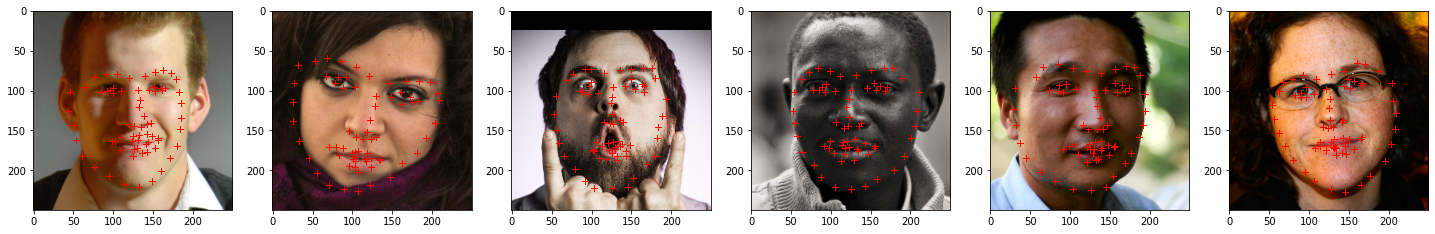

In [ ]:
#@title Example Images
# preds = model.predict(example_images/255)
# preds *= 250

# f, axarr = plt.subplots(1,6, figsize=(25,25))
# for i in range(6):
#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

#   axarr[i].imshow(example_images[i])
#   axarr[i].plot(preds[i].reshape(68,2)[:, 0], preds[i].reshape(68,2)[:, 1], '+r')

In [ ]:
#@title Import personal photos
from google.colab import files
uploaded = files.upload()

# Picture of Me.
full_path = "/content/" + "personal_image.jpg"
personal_image = cv2.imread(full_path)
personal_image = personal_image[:,150:550,:]
personal_image = cv2.resize(personal_image, (250,250), interpolation = cv2.INTER_AREA)
personal_image = cv2.cvtColor(personal_image,cv2.COLOR_BGR2RGB)
plt.imshow(personal_image)